# Trabajo Final de Astroestadística

# Objetivo:
> Clasificación de una muestra de galaxias AGN en galaxias con núcleos activos de alta excitación (HERG) y de baja excitación (LERG). Esto es, crear un algoritmo que utilice muestras de galaxias ya clasificadas en HERGs y LERGs como muestras de entrenamiento y luego aplicarlo en la identificación de galaxias clasificadas como AGNs.
## Muestras:
> Se dispone de una muestra de galaxias clasificadas como galaxias AGN, una muestra de galaxias AGN clasificadas como galaxias de tipo HERG y otra muestra de galaxias AGN clasificadas como galaxias de tipo LERG. Las tres muestras pertenecen a la muestra principial del survey Sloan (SDSS).
## Features de las muestras
> Para cada galaxia se tiene 24 features: 
- Redshift espectroscópico 
- Error en redshift 
- Masa estelar
- Caraterística espectral Dn4000
- El flujo para cuatro líneas espectrales y sus correspondientes errores
- Magnitud absoluta en los cinco filtros del Sloan
- Colores
- Magnitudes w1 y w2 del survey Wise y sus correspondientes errores

In [1]:
from astropy.table import Table
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
sns.set()

# Lectura de datos

Se leen los datos a utilizar. En la variable AGNs se guardan los datos correspondientes a las galaxias que se desean clasificar en LERGs y HERGs, luego de haber entrenado el modelo a utilizar. Las variables HERGs y LERGs poseen los datos de galaxias ya clasificadas en esos dos tipos. De estas últimas variables se obtendrán las muestras de entrenamiento y testeo. 

In [2]:
AGNs = Table.read('AGNs_noClass.fits')
AGNs = AGNs.to_pandas()
#AGNs = AGNs.drop('O3HB', axis=1)
#AGNs = AGNs.drop('N2HA', axis=1)
AGNs.columns

Index(['SNVSS', 'Z', 'Z_ERR', 'SMASS_MEDIAN', 'D4000', 'O3F', 'N2F', 'HBF',
       'HAF', 'O3F_ERR', 'N2F_ERR', 'HBF_ERR', 'HAF_ERR', 'O3HB', 'N2HA',
       'O3HB_ERR', 'MODELR', 'MODELRERR', 'PETROR', 'PETRORERR', 'ABSU',
       'ABSG', 'ABSR', 'ABSI', 'ABSZ', 'w1mpro', 'w1sigmpro', 'w2mpro',
       'w2sigmpro'],
      dtype='object')

In [3]:
HERGs = Table.read('HERGs.fits')
HERGs = HERGs.to_pandas()
#HERGs = HERGs.drop('O3HB', axis=1)
#HERGs = HERGs.drop('N2HA', axis=1)
LERGs = Table.read('LERGs.fits')
LERGs = LERGs.to_pandas()
#LERGs = LERGs.drop('O3HB', axis=1)
#LERGs = LERGs.drop('N2HA', axis=1)

Luego de la lectura se visualiza la cantidad de objetos que posee cada muestra:

In [4]:
print('HERGs = ', len(HERGs))
print('LERGs = ', len(LERGs))
print('AGNs = ', len(AGNs))

HERGs =  234
LERGs =  6212
AGNs =  1078


Se calculan y agregan como features los colores de las galaxias:

In [5]:
AGNs['g-r'] = AGNs['ABSG'] - AGNs['ABSR']
AGNs['u-r'] = AGNs['ABSU'] - AGNs['ABSU']
HERGs['g-r'] = HERGs['ABSG'] - HERGs['ABSR']
HERGs['u-r'] = HERGs['ABSU'] - HERGs['ABSR']
LERGs['g-r'] = LERGs['ABSG'] - LERGs['ABSR']
LERGs['u-r'] = LERGs['ABSU'] - LERGs['ABSR']

# Análisis exploratorio

En primer lugar se hace una limpieza de los datos, buscando los valores nan que puedan haber y cantidades negativas en características donde los valores siempre deben ser positivos. Los objetos que en alguna de sus características se cumpla lo anterior son eliminados.

In [6]:
# Valores nan en cada columna
print(np.sum(LERGs.isnull(), axis=0))
# Valores negativos en cada columna
np.sum(LERGs < 0, axis=0)

SNVSS             0
Z                 0
Z_ERR             0
SMASS_MEDIAN      0
D4000             0
O3F               0
N2F               0
HBF               0
HAF               0
O3F_ERR           0
N2F_ERR           0
HBF_ERR           0
HAF_ERR           0
O3HB            969
N2HA            709
O3HB_ERR          1
MODELR            0
MODELRERR         0
PETROR            0
PETRORERR         0
ABSU              1
ABSG              1
ABSR              1
ABSI              1
ABSZ              1
w1mpro           52
w1sigmpro        55
w2mpro           52
w2sigmpro        52
g-r               1
u-r               1
dtype: int64


SNVSS              0
Z                  0
Z_ERR              0
SMASS_MEDIAN     107
D4000              0
O3F              478
N2F              381
HBF              708
HAF              389
O3F_ERR            0
N2F_ERR           17
HBF_ERR            1
HAF_ERR           19
O3HB            2195
N2HA            2782
O3HB_ERR         968
MODELR             0
MODELRERR          0
PETROR             0
PETRORERR          0
ABSU            6211
ABSG            6211
ABSR            6211
ABSI            6211
ABSZ            6211
w1mpro             0
w1sigmpro          0
w2mpro             0
w2sigmpro          0
g-r                0
u-r                1
dtype: int64

In [7]:
# Valores nan en cada columna
print(np.sum(HERGs.isnull(), axis=0))
# Valores negativos en cada columna
np.sum(HERGs < 0, axis=0)

SNVSS           0
Z               0
Z_ERR           0
SMASS_MEDIAN    0
D4000           0
O3F             0
N2F             0
HBF             0
HAF             0
O3F_ERR         0
N2F_ERR         0
HBF_ERR         0
HAF_ERR         0
O3HB            4
N2HA            1
O3HB_ERR        0
MODELR          0
MODELRERR       0
PETROR          0
PETRORERR       0
ABSU            0
ABSG            0
ABSR            0
ABSI            0
ABSZ            0
w1mpro          2
w1sigmpro       2
w2mpro          2
w2sigmpro       2
g-r             0
u-r             0
dtype: int64


SNVSS             0
Z                 0
Z_ERR             0
SMASS_MEDIAN      2
D4000             0
O3F               0
N2F               0
HBF               4
HAF               0
O3F_ERR           0
N2F_ERR           1
HBF_ERR           0
HAF_ERR           1
O3HB              0
N2HA            133
O3HB_ERR          4
MODELR            0
MODELRERR         0
PETROR            0
PETRORERR         0
ABSU            234
ABSG            234
ABSR            234
ABSI            234
ABSZ            234
w1mpro            0
w1sigmpro         0
w2mpro            0
w2sigmpro         0
g-r               0
u-r               0
dtype: int64

In [8]:
# Valores nan en cada columna
print(np.sum(AGNs.isnull(), axis=0))
# Valores negativos en cada columna
np.sum(AGNs < 0, axis=0)

SNVSS             0
Z                 0
Z_ERR             0
SMASS_MEDIAN      0
D4000             0
O3F               0
N2F               0
HBF               0
HAF               0
O3F_ERR           0
N2F_ERR           0
HBF_ERR           0
HAF_ERR           0
O3HB            231
N2HA            272
O3HB_ERR         14
MODELR            0
MODELRERR         0
PETROR            0
PETRORERR         0
ABSU              0
ABSG              0
ABSR              0
ABSI              0
ABSZ              0
w1mpro            7
w1sigmpro         7
w2mpro            7
w2sigmpro         7
g-r               0
u-r               0
dtype: int64


SNVSS              0
Z                  0
Z_ERR              0
SMASS_MEDIAN      15
D4000              0
O3F               63
N2F               82
HBF              193
HAF              185
O3F_ERR            8
N2F_ERR           13
HBF_ERR            0
HAF_ERR           13
O3HB             203
N2HA             287
O3HB_ERR         225
MODELR             0
MODELRERR          0
PETROR             0
PETRORERR          0
ABSU            1078
ABSG            1078
ABSR            1078
ABSI            1078
ABSZ            1078
w1mpro             0
w1sigmpro          0
w2mpro             0
w2sigmpro          0
g-r                0
u-r                0
dtype: int64

Se eliminan las filas que poseen algún valor "nan" en alguna de sus columnas, a la vez que se controla la cantidad de objetos que quedan luego de esta acción.

In [9]:
AGNs = AGNs.dropna()
HERGs = HERGs.dropna()
LERGs = LERGs.dropna()
print('HERGs = ', len(HERGs))
print('LERGs = ', len(LERGs))
print('AGNs = ', len(AGNs))

HERGs =  227
LERGs =  4687
AGNs =  636


Se eliminan aquellas filas que poseen valores negativos en propiedades que deben ser sólo valores positivos. Se controla la cantidad de objetos que quedan.

In [10]:
LERGs = LERGs[LERGs['SMASS_MEDIAN'] > 0]
LERGs = LERGs[LERGs['O3F'] > 0]
LERGs = LERGs[LERGs['N2F'] > 0]
LERGs = LERGs[LERGs['HBF'] > 0]
LERGs = LERGs[LERGs['HAF'] > 0]
LERGs = LERGs[LERGs['O3F_ERR'] > 0]
LERGs = LERGs[LERGs['N2F_ERR'] > 0]
LERGs = LERGs[LERGs['HBF_ERR'] > 0]
LERGs = LERGs[LERGs['HAF_ERR'] > 0]
LERGs = LERGs[LERGs['O3HB_ERR'] > 0]
#LERGs = LERGs[LERGs['O3HB'] > 0]
#LERGs = LERGs[LERGs['N2HA'] > 0]
HERGs = HERGs[HERGs['SMASS_MEDIAN'] > 0]
HERGs = HERGs[HERGs['O3F'] > 0]
HERGs = HERGs[HERGs['N2F'] > 0]
HERGs = HERGs[HERGs['HBF'] > 0]
HERGs = HERGs[HERGs['HAF'] > 0]
HERGs = HERGs[HERGs['O3F_ERR'] > 0]
HERGs = HERGs[HERGs['N2F_ERR'] > 0]
HERGs = HERGs[HERGs['HBF_ERR'] > 0]
HERGs = HERGs[HERGs['HAF_ERR'] > 0]
HERGs = HERGs[HERGs['O3HB_ERR'] > 0]
#HERGs = HERGs[HERGs['O3HB'] > 0]
#HERGs = HERGs[HERGs['N2HA'] > 0]
HERGs = HERGs[HERGs['w1mpro'] > 0]
HERGs = HERGs[HERGs['w1sigmpro'] > 0]
HERGs = HERGs[HERGs['w2mpro'] > 0]
HERGs = HERGs[HERGs['w2sigmpro'] > 0]
AGNs = AGNs[AGNs['SMASS_MEDIAN'] > 0]
AGNs = AGNs[AGNs['O3F'] > 0]
AGNs = AGNs[AGNs['N2F'] > 0]
AGNs = AGNs[AGNs['HBF'] > 0]
AGNs = AGNs[AGNs['HAF'] > 0]
AGNs = AGNs[AGNs['O3F_ERR'] > 0]
AGNs = AGNs[AGNs['N2F_ERR'] > 0]
AGNs = AGNs[AGNs['HBF_ERR'] > 0]
AGNs = AGNs[AGNs['HAF_ERR'] > 0]
AGNs = AGNs[AGNs['O3HB_ERR'] > 0]
#AGNs = AGNs[AGNs['O3HB'] > 0]
#AGNs = AGNs[AGNs['N2HA'] > 0]
AGNs = AGNs[AGNs['w1mpro'] > 0]
AGNs = AGNs[AGNs['w1sigmpro'] > 0]
AGNs = AGNs[AGNs['w2mpro'] > 0]
AGNs = AGNs[AGNs['w2sigmpro'] > 0]
print('HERGs = ', len(HERGs))
print('LERGs = ', len(LERGs))
print('AGNs = ', len(AGNs))

HERGs =  225
LERGs =  4503
AGNs =  620


Se unen los datos en una sola tabla para facilitar su visualización gráfica y se muestra la estadística correspondiente a cada columna.

In [11]:
fulldata = pd.concat([HERGs.assign(dataset='HERG'), LERGs.assign(dataset='LERG'), AGNs.assign(dataset='AGN')])
fulldata = fulldata.reset_index()
fulldata.describe()

,index,SNVSS,Z,Z_ERR,SMASS_MEDIAN,D4000,O3F,N2F,HBF,HAF,...,ABSG,ABSR,ABSI,ABSZ,w1mpro,w1sigmpro,w2mpro,w2sigmpro,g-r,u-r
count,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,...,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000
mean,2673.173523,53.511482,0.154515,0.000075,11.346290,1.881165,39.264034,56.921406,18.296923,62.308376,...,-21.243271,-22.042463,-22.410881,-22.728525,13.505067,0.027888,13.275402,0.032104,0.799185,2.333352
std,1914.906737,201.202927,0.057989,0.003264,0.275216,0.168356,164.958069,116.565781,33.114113,236.438049,...,0.631254,0.633409,0.635144,0.633344,0.629790,0.016180,0.588033,0.008083,0.068948,0.909288
min,0.000000,5.000000,0.030168,0.000005,6.845834,0.000000,0.001011,0.006064,0.001901,0.000929,...,-23.566515,-24.091272,-24.469238,-24.758430,10.772000,0.021000,9.653000,0.020000,0.214331,0.000000
25%,862.000000,8.100000,0.109666,0.000020,11.202028,1.835048,5.776445,9.517068,4.537534,8.929416,...,-21.662521,-22.468623,-22.834325,-23.151469,13.127000,0.024000,12.938750,0.027000,0.779360,2.401226
50%,2455.500000,15.200000,0.151811,0.000028,11.372634,1.923456,12.753967,23.571222,10.093799,23.739205,...,-21.309284,-22.104459,-22.468586,-22.791571,13.626500,0.026000,13.370000,0.031000,0.799281,2.627131
75%,4356.250000,38.200001,0.196773,0.000037,11.523585,1.981682,26.185802,55.123254,19.848249,56.464562,...,-20.894287,-21.692360,-22.067284,-22.387708,13.989250,0.027000,13.709000,0.036000,0.820458,2.747468
max,6211.000000,7980.000000,0.299553,0.238743,12.707984,2.376977,4717.699219,2829.305908,694.192444,14501.028320,...,-17.281424,-17.684473,-17.862492,-17.883450,15.895000,0.384000,15.914000,0.176000,2.924061,12.337255


Se grafican las principales características de las galaxias:

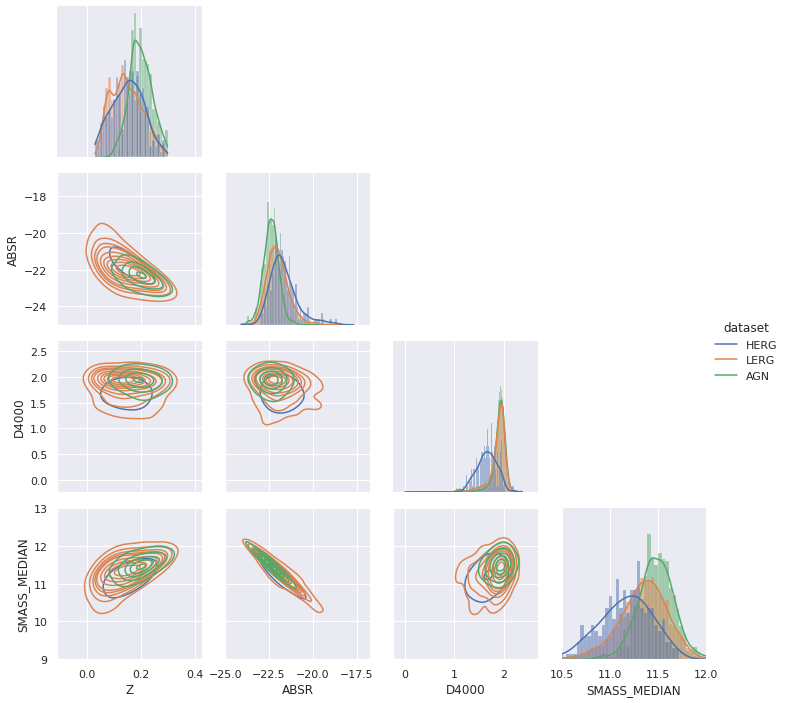

In [12]:
g = sns.PairGrid(fulldata, vars=['Z','ABSR','D4000','SMASS_MEDIAN'], hue='dataset', corner=True)
g.map_lower(sns.kdeplot, bw_adjust=2)
g.map_diag(sns.histplot, stat="probability", common_norm=False, kde=True)
g.axes[3,1].set(ylim=(9,13))
g.axes[3,2].set(ylim=(9,13))
g.axes[3,3].set(ylim=(9,13))
g.axes[3,3].set(xlim=(10.5,12))
g.add_legend()

## *Diagrama BPT*

In [ ]:
# Por el momento no se incluye por aún no decidir si se consideran en el análisis los datos
# para realizar el gráfico

In [ ]:
g = sns.jointplot(data=fulldata, x="N2HA", y="O3HB", kind="kde", hue='dataset', marginal_kws=dict(common_norm=False))
g.ax_marg_x.set_xlim(-1, 2)
g.ax_marg_y.set_ylim(-1, 2.5)

## *Diagrama de color*

(0.4, 1.1)

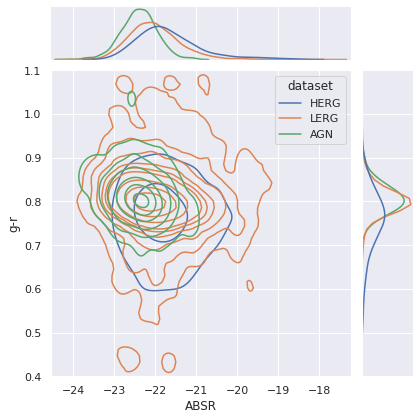

In [15]:
g = sns.jointplot(data=fulldata, x="ABSR", y='g-r', kind="kde", hue='dataset', marginal_kws=dict(common_norm=False))
#g.ax_marg_x.set_xlim(-19.5, -23.5)
g.ax_marg_y.set_ylim(0.4, 1.1)

## *Análisis PCA*

Se realiza un análisis de componentes principales para explorar la cantidad de información aportada por las distintas características de los objetos de las muestras.

In [16]:
# Se normalizan los datos
ss = StandardScaler()
fulldata = fulldata.drop('dataset', axis=1)
datanorm = ss.fit_transform(fulldata)

In [17]:
pca = PCA()
pca.fit(datanorm)
comp = pca.transform(datanorm)
mean = pca.mean_
components = pca.components_
var = pca.explained_variance_ratio_
var = np.cumsum(var)

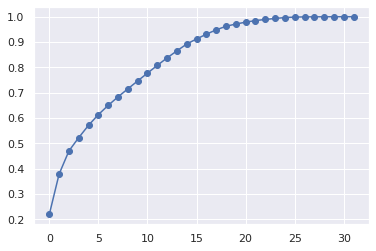

In [18]:
plt.plot(var, marker='o')

El gráfico anterior muestra que con 15 componentes ya se está tomando más del 90% de la información contenida en las tablas de datos.

# Training

En esta sección se entrena el modelo a utilizar para la clasificación de la muestra de AGNs. El modelo elegido es el Random Forest.

#### Elección del modelo

In [19]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'random_state',
 'ccp_alpha')

#### Busqueda de los hyperparámetros óptimos

In [23]:
# Se le asigna valores enteros a la variable categórica que indica la clase de cada objeto.
# El valor 0 indica si el objeto es HERG y el valor 1 indica si es LERG.
classsample = pd.concat([HERGs.assign(AGN_Tipe='HERG'), LERGs.assign(AGN_Tipe='LERG')])
le = LabelEncoder()
classsample['AGN_Tipe'] = le.fit_transform(classsample['AGN_Tipe'])

In [24]:
ind_vars = classsample.drop(['AGN_Tipe'], axis=1)
dep_vars = classsample['AGN_Tipe']

In [25]:
from sklearn.model_selection import RandomizedSearchCV

n_est= list(range(600, 900,50))
max_d=list(range(10, 20))
min_split= list(range(2, 12))
min_leaf=list(range(1,8))
weight_options = ['balanced', 'balanced_subsample']

param_dist = dict(n_estimators=n_est, max_depth=max_d, min_samples_split=min_split, min_samples_leaf=min_leaf, class_weight=weight_options)

rand = RandomizedSearchCV(model, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=3210)
rand.fit(ind_vars, dep_vars)
pd.DataFrame(rand.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

print(rand.best_score_)
print(rand.best_params_)

0.982232952305873
{'n_estimators': 600, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 18, 'class_weight': 'balanced_subsample'}


In [26]:
model = RandomForestClassifier(n_estimators=600, min_samples_split=4, min_samples_leaf=3,
                              max_depth=18, class_weight='balanced_subsample')

#### Precisión del modelo

Se hace uso de la validación cruzada para determinar la precisión promedio del modelo. Para esto se prueba el modelo 10 veces cambiando la muestra de entrenamiento y de test en cada ocasión.

In [27]:
from sklearn.model_selection import cross_validate
scores = np.zeros(10)
for i, score in enumerate(cross_validate(model, ind_vars, dep_vars, cv=10)["test_score"]):
    print(f"Precisón para la prueba {i}: {score}")
    scores[i] = score
print('Precisión promedio: ', scores.mean())
print('Desvío estándar: ', scores.std())

Precisón para la prueba 0: 0.9809725158562368
Precisón para la prueba 1: 0.9788583509513742
Precisón para la prueba 2: 0.9894291754756871
Precisón para la prueba 3: 0.9767441860465116
Precisón para la prueba 4: 0.9809725158562368
Precisón para la prueba 5: 0.9788583509513742
Precisón para la prueba 6: 0.9809725158562368
Precisón para la prueba 7: 0.985200845665962
Precisón para la prueba 8: 0.9809322033898306
Precisón para la prueba 9: 0.9788135593220338
Precisión promedio:  0.9811754219371485
Desvío estándar:  0.0034707785006189125


#### Muestra de training y test

In [28]:
ind_vars_train, ind_vars_test, dep_vars_train, dep_vars_test = train_test_split(ind_vars, dep_vars, shuffle=True, stratify=dep_vars)
print('Cantidad de LERGs en la muestra de entrenamiento: ', np.sum(dep_vars_train == 1))
print('Cantidad de HERGs en la muestra de entrenamiento: ', np.sum(dep_vars_train == 0))
print('Cantidad de LERGs en la muestra de testeo: ', np.sum(dep_vars_test == 1))
print('Cantidad de HERGs en la muestra de testeo: ', np.sum(dep_vars_test == 0))
print('Distribución de clases en entrenamiento')
print(dep_vars_train.value_counts(normalize=True))
print('Distribución de clases en testeo')
print(dep_vars_test.value_counts(normalize=True))

Cantidad de LERGs en la muestra de entrenamiento:  3377
Cantidad de HERGs en la muestra de entrenamiento:  169
Cantidad de LERGs en la muestra de testeo:  1126
Cantidad de HERGs en la muestra de testeo:  56
Distribución de clases en entrenamiento
1    0.952341
0    0.047659
Name: AGN_Tipe, dtype: float64
Distribución de clases en testeo
1    0.952623
0    0.047377
Name: AGN_Tipe, dtype: float64


#### Entrenamiento y testeo

In [29]:
model_fit = model.fit(ind_vars_train, dep_vars_train)
model_pred = model_fit.predict(ind_vars_test)
print("Precisión: ", (accuracy_score(model_pred, dep_vars_test)*100))
print()
print('Matriz de confusión')
print(pd.DataFrame(confusion_matrix(dep_vars_test, model_pred),columns=['pred_0', 'pred_1']))

Precisión:  97.71573604060913

Matriz de confusión
   pred_0  pred_1
0      44      12
1      15    1111


#### Ajuste del threshold

Las clases con las que se entrena el modelo están desbalanceadas, ya que para una se tiene una cantidad de 200 objetos mientras que para la otra son más de 4000. Por esto, es recomendable ajustar el umbral de decisón (threshold) para lo cual se hace uso de la función ROC:

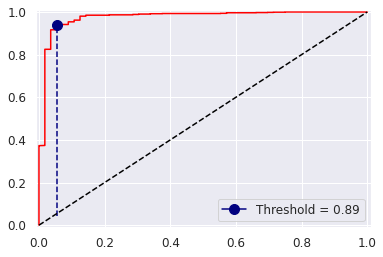

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
model_pred_p = model_fit.predict_proba(ind_vars_test)[:, 1]
FPR, TPR, Thresholds = roc_curve(dep_vars_test, model_pred_p)
auc = roc_auc_score(dep_vars_test, model_pred_p)
youden_idx = np.argmax(np.abs(TPR - FPR))
youden_threshold = Thresholds[youden_idx]
y_pred_youden = (model_pred_p > youden_threshold).astype(int)

plt.plot(FPR, TPR, color = "red")
plt.plot(FPR[youden_idx], TPR[youden_idx], marker = "o", color = "navy", ms =10, label =F"Threshold = {youden_threshold:.2f}" )
plt.axvline(x = FPR[youden_idx], ymin = FPR[youden_idx], ymax = TPR[youden_idx], color = "navy", ls = "--")
plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)

# Clasificación de AGNs

Una vez entrenado el modelo se lo utiliza para clasificar la muestra de objetos AGNs.

In [31]:
model_pred = model.predict_proba(AGNs)
model_pred

array([[0.00441326, 0.99558674],
       [0.00930972, 0.99069028],
       [0.00592202, 0.99407798],
       ...,
       [0.00592946, 0.99407054],
       [0.08710333, 0.91289667],
       [0.00918487, 0.99081513]])

## Visualización de la clasificación

Los objetos clasificados como LERGs son guardados en la variable newLERGs. Los clasificados como HERGs se encuentran en la variable newHERGs

In [32]:
newLERGs = AGNs[np.array(model_pred[:,1]) > 0.95]
print('Cantidad en newLERGs = ', len(newLERGs))

Cantidad en newLERGs =  558


In [33]:
newHERGs = AGNs[np.array(model_pred[:,0]) > 0.5]
print('Cantidad en newHERGs = ', len(newHERGs))

Cantidad en newHERGs =  1


### Comparación entre la muestra de LERGs y las AGNs clasificadas como LERGs por medio del algoritmo.

In [34]:
fulldataLERG = pd.concat([LERGs.assign(dataset='LERG'), newLERGs.assign(dataset='newLERGs')])
fulldataLERG = fulldataLERG.reset_index()

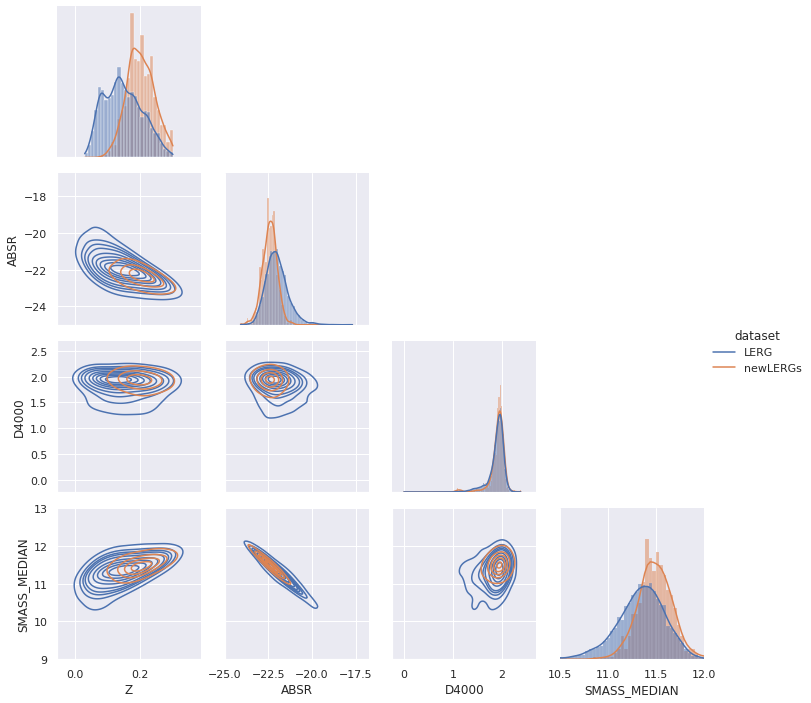

In [35]:
g = sns.PairGrid(fulldataLERG, vars=['Z','ABSR','D4000','SMASS_MEDIAN'], hue='dataset', corner=True)
g.map_lower(sns.kdeplot, bw_adjust=2)
g.map_diag(sns.histplot, stat="probability", common_norm=False, kde=True)
g.axes[3,1].set(ylim=(9,13))
g.axes[3,2].set(ylim=(9,13))
g.axes[3,3].set(ylim=(9,13))
g.axes[3,3].set(xlim=(10.5,12))
g.add_legend()

In [ ]:
#g = sns.jointplot(data=fulldataLERG, x="N2HA", y="O3HB", kind="kde", hue='dataset', marginal_kws=dict(common_norm=False))
#g.ax_marg_x.set_xlim(-1, 2)
#g.ax_marg_y.set_ylim(-1, 2.5)

(0.4, 1.1)

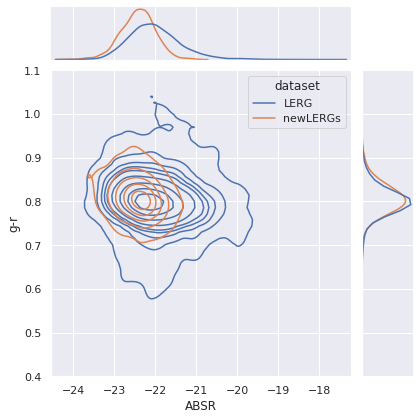

In [37]:
g = sns.jointplot(data=fulldataLERG, x="ABSR", y='g-r', kind="kde", hue='dataset', marginal_kws=dict(common_norm=False))
#g.ax_marg_x.set_xlim(-19.5, -23.5)
g.ax_marg_y.set_ylim(0.4, 1.1)

### Comparación entre la muestra de HERGs y las AGNs clasificadas como HERGs por medio del algoritmo.

In [ ]:
fulldataHERG = pd.concat([HERGs.assign(dataset='HERG'), newHERGs.assign(dataset='newHERGs')])
fulldataHERG = fulldataHERG.reset_index()

In [ ]:
g = sns.PairGrid(fulldataHERG, vars=['Z','ABSR','D4000','SMASS_MEDIAN'], hue='dataset', corner=True)
g.map_lower(sns.kdeplot, bw_adjust=2)
g.map_diag(sns.histplot, stat="probability", common_norm=False, kde=True)
g.axes[3,1].set(ylim=(9,13))
g.axes[3,2].set(ylim=(9,13))
g.axes[3,3].set(ylim=(9,13))
g.axes[3,3].set(xlim=(10.5,12))
g.add_legend()

In [ ]:
g = sns.jointplot(data=fulldataHERG, x="N2HA", y="O3HB", kind="kde", hue='dataset', marginal_kws=dict(common_norm=False))
g.ax_marg_x.set_xlim(-1, 2)
g.ax_marg_y.set_ylim(-1, 2.5)

In [ ]:
sns.jointplot(data=fulldataHERG, x="ABSR", y='g-r', kind="kde", hue='dataset', marginal_kws=dict(common_norm=False))